# I. Parametric vs non-parametric regression

In [1]:
# Some boilerplate code: importing matplotlib and numpy
%matplotlib inline
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt

Let us define the random variables $X$ and $Y$ by
$$
f(x) = x \frac{1 + x}{1 + x^2}, \qquad X \sim \mathcal{N}(0, 1), \quad Y = f(X) + \varepsilon,
$$
where $\varepsilon \sim \mathcal{N}(0, 1/4)$ is independent of X

In [2]:
# Simulation of a sample for the distribution defined above
def f(x):
    return (x + x ** 2) / (1. + x ** 2)

n = 1000
sigma = 0.5
X = np.random.randn(n)
Y = f(X) + sigma * np.random.randn(n)

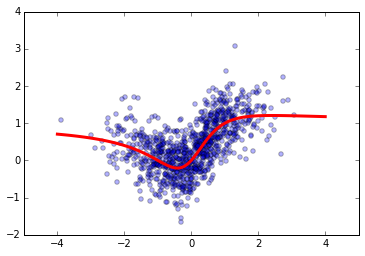

In [3]:
# Plot a random sample of the joint distribution and the 
# theoretical conditional expectation of Y wrt X.
plt.scatter(X, Y, alpha=0.3)
mesh = np.linspace(-4, 4, 101)
plt.plot(mesh, f(mesh), 'r', linewidth=3)
plt.show()

## Non-parametric regression

In [4]:
# Non-parametric regression function

def reg_non_param(x, bdwidth, x_sample, y_sample):
    """Values of the non-parametric regression of Y wrt X using a Gaussian kernel.

    Parameters
    ----------
    x: numpy array, one dimensional
        Values at which the regression is evaluated
    bdwidth: positive float, value of the bandwidth parameter
    x_sample: numpy array, one dimensional, non-empty
        x values of the sample
    y_sample: numpy array, one dimensional
        y values of the sample, must have the same length as x_sample.    
    """
    def kern(u, x):
        """Gaussian kernel function"""
        return np.exp(-(u[:, np.newaxis] - x) ** 2 / (2 * bdwidth ** 2))

    return np.sum(kern(x_sample, x) * y_sample[:, np.newaxis], axis=0) \
        / np.sum(kern(x_sample, x), axis=0)

Plotting non-parametric regressions of $Y$ with respect to $X$ with different values of the bandwidth:

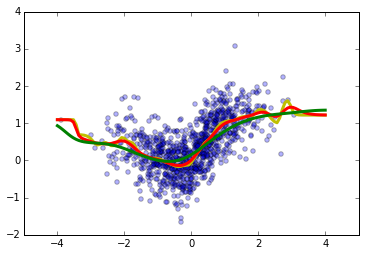

In [5]:
# Plotting the 10 basis functions corresponding to 10 knots equi-spaced on [-3, 3].

plt.scatter(X, Y, alpha=0.3)
plt.plot(mesh, reg_non_param(mesh, 0.1, X, Y), 'y', linewidth=3)
plt.plot(mesh, reg_non_param(mesh, 0.2, X, Y), 'r', linewidth=3)
plt.plot(mesh, reg_non_param(mesh, 0.5, X, Y), 'g', linewidth=3)
plt.show()

## Multiple regression

In [6]:
def basis(knots, x):
    """Values of order-1 B-spline basis functions.
    
    For an increasingly sorted collection of knots and a collection of
    query points x, returns a 2-dimensional array of values, of dimension
    len(x) x len(knots).
    
    Parameters
    ----------
    knots: numpy array, one dimensional, increasingly sorted
        Knots of the B-spline function
    x: numpy array, one dimensional
        Query points where to evaluate the basis functions.
    """
    nb_knots = len(knots)
    diag = np.identity(nb_knots)
    res = np.empty((len(x), nb_knots))
    for i in xrange(nb_knots):
        res[:, i] = np.interp(x, knots, diag[i])
    return res

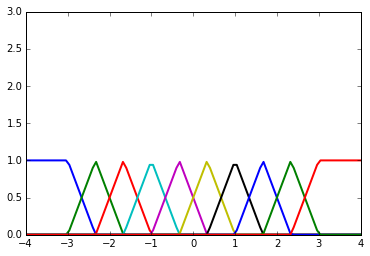

In [7]:
# Plotting the 10 basis functions corresponding to 10 knots equi-spaced on [-3, 3]
basis_len = 10
knots = np.linspace(-3.0, 3.0, basis_len)
plt.plot(mesh, basis(knots, mesh), linewidth=2)
plt.ylim(0.0, 3)
plt.show()

## Questions on regression methods

#### **1.** Perform the piecewise linear regression of $Y$ with respect to $X$, where $X$ and $Y$ are the random variables defined earlier, using a multidimensional regression of $Y$ onto the order-1 basis functions $(b_i(X))_{i \in \{1,\ldots ,k\}}$, and plot the results.


In [8]:
def reg_param_coeffs(knots, x_sample, y_sample):
    """Computes the coefficients of the P-L regression of y_sample wrt. x_sample.
    
    For an increasingly sorted collection of knots and two one-dimensional
    samples x_sample and y_sample, computes the PL-regression.
    
    Parameters
    ----------
    knots: numpy array, one dimensional, increasingly sorted
        Knots of the B-spline function
    x_sample: numpy array, one dimensional
        X sample
    y_sample: numpy array, one dimensional
        Y sample
        
    Notes
    -----
    The length of the X and Y samples must be the same.
    The length of the knots array should be at least one.
    The knots must be increasingly sorted.
    """
    bis = basis(knots, x_sample)
    var = bis.T.dot(bis)
    covar = y_sample.dot(bis)
    return np.linalg.lstsq(var, covar.T)[0]

In [9]:
def eval_piecewise_linear(x, knots, coeffs):
    """Eveluates the piecewise linear function at the specified x for the
    specified knots and coeffs.
    
    This is simply a wrapper around np.interp.
    """
    return np.interp(x, knots, coeffs)

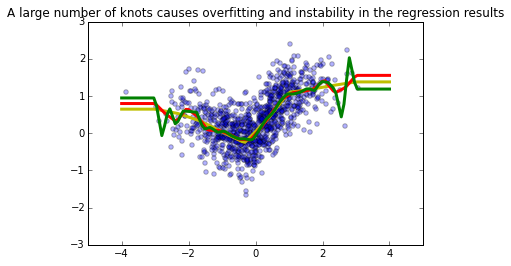

In [10]:
# Plotting the results of the regression with different number of knots.
# Observe the overfitting when using many knots compared to the sample size (green line).

plt.scatter(X, Y, alpha=0.3)

knots1 = np.linspace(-3.0, 3.0, 10)
plt.plot(mesh, eval_piecewise_linear(mesh, knots1, reg_param_coeffs(knots1, X, Y)), 'y', linewidth=3)

knots2 = np.linspace(-3.0, 3.0, 20)
plt.plot(mesh, np.interp(mesh, knots2, reg_param_coeffs(knots2, X, Y)), 'r', linewidth=3)

knots3 = np.linspace(-3.0, 3.0, 30)
plt.plot(mesh, np.interp(mesh, knots3, reg_param_coeffs(knots3, X, Y)), 'g', linewidth=3)

plt.ylim(-3, 3)
plt.title('A large number of knots causes overfitting and instability in the regression results')
plt.show()

#### **2.** Experiment with 
 - various kernel functions, bandwidth values, and sample sizes (non-parametric regression),
 - with various sample sizes and number of basis functions (piecewise linear regression). Compare and comment the results.
 
#### **3.** Bonus question: Experiment with second-order Tikhonov regularization.

The second derivative of a piecewise-linear function being a Dirac comb. The penalization should be the sum of the squares of the weights of those Dirac masses.

In [11]:
# Solution to the bonus question: Tikhonov-regularized piecewise linear regression.

def second_derivative_on_dirac_basis(knots):
    """
    Computes the coefficients of the second derivative of the basis functions
    on the Dirac comb.
    """
    nb_knots = len(knots)
    res = np.zeros((nb_knots, nb_knots))
    if nb_knots > 1:
        res[0, 0] = -1.0 / (knots[1] - knots[0])
        res[0, 1] = 1.0 / (knots[1] - knots[0])
    for i in xrange(1, nb_knots - 1):
        res[i, i - 1] = (1.0 / (knots[i] - knots[i - 1]))
        res[i, i] = -(1.0 / (knots[i] - knots[i - 1]) + 1.0 / (knots[i + 1] - knots[i]))
        res[i, i + 1] = 1.0 / (knots[i + 1] - knots[i])
    if nb_knots > 1:
        res[nb_knots - 1, nb_knots - 2] = 1.0 / (knots[nb_knots - 1] - knots[nb_knots - 2])
        res[nb_knots - 1, nb_knots - 1] = -1.0 / (knots[nb_knots - 1] - knots[nb_knots - 2])
    return res

def dirac_inner_product(knots, coeffs1, coeffs2):
    """
    Equivalent to the finite-difference approximation for the second derivative.
    """
    nb_knots = len(knots) 
    res = 0.0
    for i in xrange(nb_knots):
        res += 0.5 * (coeffs1[i] * coeffs2[i] + coeffs1[i - 1] * coeffs2[i - 1]) / (knots[i] - knots[i - 1])
    return res

def tikhonov_matrix(knots):
    """Computes the second-order Tikhonov matrix of the B-splines corresponding to specified knots.
    
    Note
    ----
    The specified array of knots must be non-empty and increasingly sorted.
    """
    basis_len = len(knots)
    res = np.zeros((basis_len, basis_len))
    coeffs_on_dirac_basis = second_derivative_on_dirac_basis(knots)
    influence_order = 2
    for i in xrange(basis_len):
        min_j = max(0, i - influence_order)
        max_j = min(basis_len, i + influence_order + 1)
        for j in xrange(min_j, max_j):
            res[i, j] = dirac_inner_product(knots, coeffs_on_dirac_basis[i], coeffs_on_dirac_basis[j])
    return res

In [12]:
def penalized_pl_regression(knots, x_sample, y_sample, tikhonov_factor):
    """Compute the second-order penalized P-L regression of y_sample wrt. x_sample.
    """
    bis = basis(knots, x_sample)
    var = (bis.T).dot(bis) / len(x_sample)
    covar = y_sample.dot(bis) / len(x_sample)
    tikho = tikhonov_matrix(knots)
    
    return np.linalg.lstsq(var + tikhonov_factor * tikho, covar.T)[0]

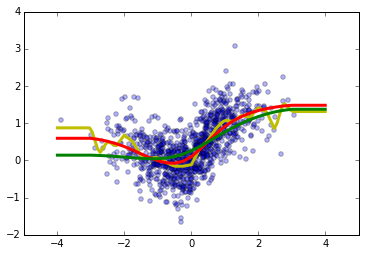

In [13]:
# Plotting the results of the regression with different number of knots.
# Observe the overfitting when using many knots compared to the sample size (green line).

plt.scatter(X, Y, alpha=0.3)
knots = np.linspace(-3.0, 3.0, 25)
plt.plot(mesh, eval_piecewise_linear(mesh, knots, penalized_pl_regression(knots, X, Y, 0.0)), 'y', linewidth=3)
plt.plot(mesh, eval_piecewise_linear(mesh, knots, penalized_pl_regression(knots, X, Y, 0.01)), 'r', linewidth=3)
plt.plot(mesh, eval_piecewise_linear(mesh, knots, penalized_pl_regression(knots, X, Y, 0.1)), 'g', linewidth=3)
plt.show()

# II. American Option Pricing: The American Put in the Black-Scholes model

In [14]:
# Model
S0 = 100
r = 0.05
sigma = 0.2
T = 1.0

# Payoff: ATM Put
K = 100

def payoff(x):
    return np.maximum(K - x, 0)

# Sample size and time discretization
nb_mc = 4000
nb_step = 20

In [15]:
## Utility function for simulating Black-Scholes paths

def bs_path(nb_step, nb_mc, S0, r, sigma, T):
    """Simulate geometric Brownian motion
    
    Parameters
    ----------
    nb_step: integer, greater than 1
        number of time steps
    nb_mc: positive integer
        sample size
    S0: positive float
        starting value
    r: float
        drift
    sigma: float
        volatility
    T: positive float
        maturity
    """
    brownian = np.empty((nb_step + 1, nb_mc))
    brownian[0] = 0.0
    brownian[1:] = np.cumsum(np.random.randn(nb_step, nb_mc), axis=0) * np.sqrt(T / nb_step)

    return S0 * np.exp(sigma * brownian + (r - 0.5 * sigma ** 2) * np.linspace(0.0, T, nb_step + 1)[:, np.newaxis])

## Simulation of a few path of geometric Brownian motion

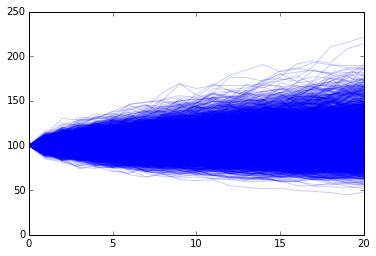

In [16]:
plt.figure()
plt.plot(bs_path(nb_step, nb_mc, S0, r, sigma, T), 'b', alpha=0.2)
plt.show()

## Tsitsiklis-van Roy algorithm

#### We provide a simplistic implementation of the TVR algorithm.

Price from TVR backward induction (non-parametric):  7.05484837944


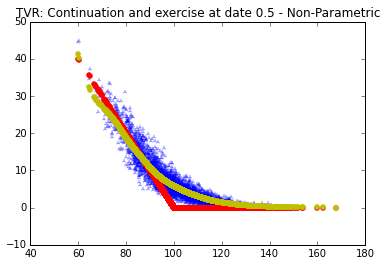

In [17]:
path = bs_path(nb_step, nb_mc, S0, r, sigma, T)
price = payoff(path[-1])

# Dynamic programming
for index in range(nb_step):
    i = nb_step - index - 1
    discount = np.exp(-r * T / nb_step)
    exercise = payoff(path[i])
    if i != 0:
        continuation = reg_non_param(path[i], 0.2 * np.std(path[i]), path[i], discount * price)
    else:
        continuation = np.mean(discount * price)
    # intermediate plot at mid time step
    if i == nb_step / 2:
        plt.scatter(path[i], discount * price, marker='2', alpha=0.4)
        plt.scatter(path[i], exercise, color='r')
        plt.scatter(path[i], continuation, color='y')
        plt.title('TVR: Continuation and exercise at date %s' % (i * T / nb_step) + ' - Non-Parametric')
    price = np.maximum(exercise, continuation)
print('Price from TVR backward induction (non-parametric): ', np.mean(price))

The price from the backward induction from TVR is generally too high because regression errors accumulate in a positive fashion.

**1.** Experiment with various values of interest rates. Comment on the dependence of the American Put price on interest rate.

**2.** Adapt the TVR code to use the piecewise linear regression method implemented for the previous section.

Price from TVR backward induction (piecewise-linear):  5.95161691413


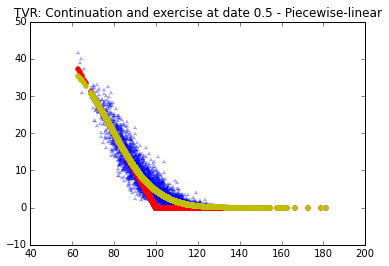

In [18]:
# Version of the TVR backward induction using the Piecewise-linear regression implemented earlier

path = bs_path(nb_step, nb_mc, S0, r, sigma, T)
price = payoff(path[-1])

nb_knots = 20
std = np.std(path[-1])
knots = np.linspace(S0 - 2 * std, S0 + 2 * std, nb_knots)

# Dynamic programming
for index in range(nb_step):
    i = nb_step - index - 1
    discount = np.exp(-r * T / nb_step)
    exercise = payoff(path[i])
    if i != 0:
        tikho = 0.5 * std ** 3 / nb_mc
        coeffs = penalized_pl_regression(knots, path[i], discount * price, tikho)
        continuation = eval_piecewise_linear(path[i], knots, coeffs)
    else:
        continuation = np.mean(discount * price)
    # intermediate plot at mid time step
    if i == nb_step / 2:
        plt.scatter(path[i], discount * price, marker='2', alpha=0.4)
        plt.scatter(path[i], exercise, color='r')
        plt.scatter(path[i], continuation, color='y')
        plt.title('TVR: Continuation and exercise at date %s' % (i * T / nb_step) + ' - Piecewise-linear')
    price = np.maximum(exercise, continuation)
print('Price from TVR backward induction (piecewise-linear): ', np.mean(price))

In [19]:
# Corresponding European option price
print('Estimation of the corresponding European option price: ', np.mean(np.exp(-r * T) * payoff(path[-1])))

Estimation of the corresponding European option price:  5.44077333745


#### **3.** For each discretization date, compute the exercise boundary. Draw a plot of the exercise boundary as a function of the date.

In [20]:
# Version of the TVR backward induction where we evaluate the exercise boundary.
# The value used for the exercise boundary is the largest spot value for which exercise
# price is greater than continuation price

path = bs_path(nb_step, nb_mc, S0, r, sigma, T)
price = payoff(path[-1])

mesh = np.linspace(70.0, 130.0, 100)
frontiers  = []
# Dynamic programming
for index in range(nb_step):
    i = nb_step - index - 1
    discount = np.exp(-r * T / nb_step)
    exercise = payoff(path[i])
    exercise_mesh = payoff(mesh)
    if i != 0:
        continuation = reg_non_param(path[i], 0.2 * np.std(path[i]), path[i], discount * price)
        continuation_mesh = reg_non_param(mesh, 0.2 * np.std(path[i]), path[i], discount * price)
    else:
        continuation = np.mean(discount * price)
        continuation_mesh = continuation
    frontiers.append(mesh[exercise_mesh > continuation_mesh][-1])
    price = np.maximum(exercise, continuation)
frontiers = frontiers[::-1]
frontiers.append(K)
frontiers = np.array(frontiers)

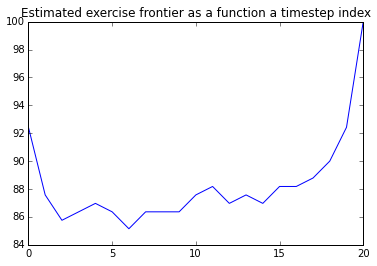

In [21]:
plt.plot(frontiers)
plt.title('Estimated exercise frontier as a function a timestep index')

The exercise frontier is increasing and converges to the strike at maturity. The irregularity of the exercise frontier is due to regression errors varying between time steps.

#### **4.** Perform an independent Monte Carlo simulation using this exercise boundary as an exercise policy, and estimate the price of the American put. Explain why this estimate is a lower bound.

In [22]:
large_nb_mc = 100000
path = bs_path(nb_step, large_nb_mc, S0, r, sigma, T)

ssum = 0.0
for i in xrange(large_nb_mc):
    for j in xrange(nb_step + 1):
        if path[j, i] < frontiers[j]:
            ssum += np.exp(- r * j * T / nb_step) * payoff(path[j, i])
            break
    else:
        ssum += np.exp(- r * j * T / nb_step) * payoff(path[j, i])
        
ssum /= large_nb_mc

print(ssum)

6.00796186319


This is a lower bound of the price based on the approximation of the exercise frontier

## Lonstaff-Schwartz Algorithm

#### We provide a simplistic implementation of the LS algorithm.

Price from LS backward induction:  6.02749391929


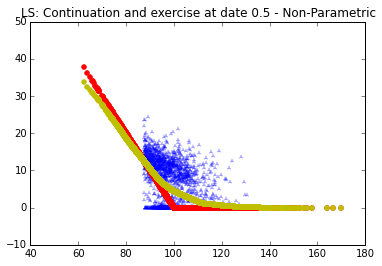

In [23]:
path = bs_path(nb_step, nb_mc, S0, r, sigma, T)
price = payoff(path[-1])

# tau is the current estimation of the index of the stopping time
# assuming that we have not exercised so far.
# At the last date, it is equal to the last date index.
tau = np.ones(nb_mc, dtype=np.int) * nb_step

mesh = np.linspace(70.0, 130.0, 100)
frontiers  = []

regressions = []

# Backward induction
for index in range(nb_step):
    i = nb_step - index - 1
    discount = np.exp(-r * T / nb_step)
    exercise = payoff(path[i])
    exercise_mesh = payoff(mesh)

    if i != 0:
        continuation = reg_non_param(path[i], 0.2 * np.std(path[i]), path[i], discount * price)
        # Estimating the continuation value on a regular mesh to compute the exercise frontier.
        continuation_mesh = reg_non_param(mesh, 0.2 * np.std(path[i]), path[i], discount * price)
    else:
        continuation = np.mean(discount * price)
        continuation_mesh = continuation * np.ones(mesh.shape)
    regressions.append(continuation_mesh)
    frontiers.append(mesh[exercise_mesh > continuation_mesh][-1])
    exercise_now = exercise > continuation
    tau = np.where(exercise_now, i, tau)
    price = np.where(exercise_now, exercise, discount * price)

    # intermediate plot at mid time step
    if i == nb_step / 2:
        plt.scatter(path[i], discount * price, marker='2', alpha=0.4)
        plt.scatter(path[i], exercise, color='r')
        plt.scatter(path[i], continuation, color='y')
        plt.title('LS: Continuation and exercise at date %s' % (i * T / nb_step) + ' - Non-Parametric')
        
frontiers = frontiers[::-1]
regressions = regressions[::-1]
frontiers.append(K)
frontiers = np.array(frontiers)

print('Price from LS backward induction: ', np.mean(price))

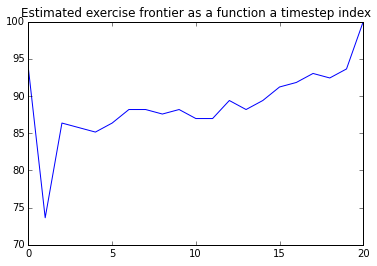

In [24]:
plt.plot(frontiers)
plt.title('Estimated exercise frontier as a function a timestep index')

As expected the scatter plot has more variance in the case of the Longstaff-Schwartz algorithm.

In [25]:
large_nb_mc = 100000
path = bs_path(nb_step, large_nb_mc, S0, r, sigma, T)

ssum = 0.0
for i in xrange(large_nb_mc):
    for j in xrange(nb_step + 1):
        if path[j, i] < frontiers[j]:
            ssum += np.exp(- r * j * T / nb_step) * payoff(path[j, i])
            break
    else:
        ssum += np.exp(- r * T) * payoff(path[-1, i])
        
ssum /= large_nb_mc

print(ssum)

6.01607231937


# Dual methods for American option pricing

In [26]:
# Generating a new Monte Carlo sample and computing the Snell envelope at the corresponding values

large_nb_mc = 100000
path = bs_path(nb_step, large_nb_mc, S0, r, sigma, T)
snell  = np.empty(path.shape)
disc = np.exp(-r * np.linspace(0.0, T, nb_step + 1))[:, np.newaxis]

for i in range(nb_step):
    snell[i] = np.maximum(payoff(path[i]), eval_piecewise_linear(path[i], mesh, regressions[i]))
snell[nb_step] = payoff(path[nb_step])

snell = disc * snell

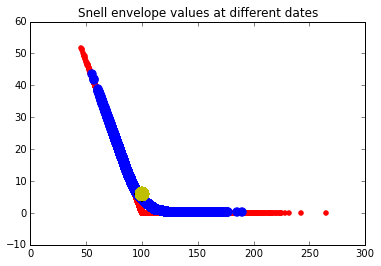

In [27]:
plt.scatter(path[-1], snell[-1], color='r')
plt.scatter(path[10], snell[10], s=70, color='b')
plt.scatter(path[0], snell[0], s=170, color='y')
plt.title('Snell envelope values at different dates')
plt.show()

Extracting the Martingale part of the snell envelope:

- the martingale increments $M_{t_i} - M_{t_{i-1}}$ are equal to $S_{t_i} - E[S_{t_i}|X_{t_{i-1}}]$.
- the conditional expectation in this term can decomposed in two parts, with the indicators of
    - $\tau_{i-1} = t_{i-1}$,
    - $\tau_{i-1} > t_{i-1}$,
    We have, $\mathbb{1}_{\tau_{i-1} > t_{i-1}} E[S_{t_i}|X_{t_{i-1}}] =  \mathbb{1}_{\tau_{i-1} > t_{i-1}} S_{t_{i-1}}$, so that $M_{t_i} - M_{t_{i-1}} = (S_{t_i} - S_{t_{i-1}}) - \mathbb{1}_{\tau_{i-1} = t_{i-1}} (E[S_{t_i}|X_{t_{i-1}}] - S_{t_{i-1}})$.

The benefit of this transformation is that estimating the conditional expectation is only required in $\mathbb{1}_{\tau_{i-1} = t_{i-1}}$, ie. in the exercise region. Bellow, we propose a first implementation of the dual method.

In [28]:
# Extracting the Martingale part of Doob-Meyer decomposition of the Snell envelope.
mart = np.empty(path.shape)

# The martingale starts from zero.
mart[0] = 0
for i in range(nb_step):
    # Compute the exercise region at each date.
    should_exercise = eval_piecewise_linear(path[i], mesh, regressions[i]) < payoff(path[i])

    # Compute the martingale increments / 
    martingale_increment = np.zeros(large_nb_mc)
    for j in range(large_nb_mc):
        if should_exercise[j]:
            # Take a small mc sample from ti to ti + 1
            small_mc = bs_path(1, 100, path[i, j], r, sigma, T / nb_step)
            # Compute the conditional expectation
            if i != nb_step - 1:
                condexp = np.mean(np.maximum(eval_piecewise_linear(small_mc, mesh, regressions[i + 1]),
                                             payoff(small_mc)))
            else:
                condexp = np.mean(payoff(small_mc))
            condexp *= np.exp(-r * T * (i + 1) / nb_step)
            martingale_increment[j] = snell[i + 1][j] - condexp
        else:
            martingale_increment[j] = snell[i + 1][j] - snell[i][j]

    # Add the martingale increment
    mart[i + 1] = mart[i] + martingale_increment

In [29]:
# Use this martingale to evaluate the american option price

price = np.mean(np.max(disc * payoff(path) - mart, axis=0))
print('Dual approach price: ', price)

Dual approach price:  6.08211348601


## Assignment II

- Provide an annotated version of the Longstaff-Schwartz algorithm and the dual method implemented in earlier cells. 
    - Use a markdown cell with code areas to interleave code and detailed comments.

- How does this differ from the classical Andersen-Broadie algorithm described in the attached pdf?
    
- Reusing the exercise policy computed with the Longstaff-Schwartz algorithm, provide an implementation of the dual Andersen-Broadie method for the ATM American Put.

# LONGSTAFF-SCHWARTZ ALGORITHM

We evaluate the expression
$\hat{C}(X_{m-1}) < h_{m-1}(X_{m-1})$ , that is, $continuation(t_{i-1}) < exercise(t_{i-1})$

if this expression is true, we set, in all cases:
$V_{m-1}=h_{m-1}(X_{m-1})$  In other words, if the value of exercise is higher, we choose to exercise.

If that expression is not true, then we do:

TVR: $V_{m-1} = h_{m-1}(X_{m-1})$

LS: $V_{m-1}=V_{m}$

It is said that TVR and LS have similar accuracy, but that LS will tend to produce less error.

We know that value of an option at maturity is the exercise value, or $V_{m}(X_{m})=h_{m}(X_{m})$
For example, we define maturity as T, where 1>t>n.  We say $t_{n}=T$.  $V(X_{n})=h_{n}(X_{n}$, the value at exercise.

We then want to evaluate the value at n-1.  If $\hat{C}(X_{n-1}) < h_{n-1}(X_{n-1})$ is true, then we set $V_{n-1}=h_{n-1}(X_{n-1})$, that is, we exercise the option and the options value becomes the value of exercise.
If this is not true, then, under TVR, we would have $V_{n-1} = h_{n-1}(X_{n-1})$, that is, we use the continuation value we have calculated.
Under LS, we simply use the last value of the option that we have calculated: $V_{n-1}=V_{n}$.  Since we have calculated the value at maturity, then we say that the value at n-1 is equal to value at maturity, and we continue to loop through to find the value of n-2.  We are then looking for a case where the value of continuation is greater than the value of exercise.

First we generate 

```python
path = bs_path(nb_step, nb_mc, S0, r, sigma, T)
price = payoff(path[-1])
```


tau is the current estimation of the index of the stopping time
assuming that we have not exercised so far.  By default it is a vector of ones (indicating that the stopping time it t=1).  We multiply by nb_step to put this in "step order" eg the final time is nb_step, since we will later be indexing with i from 1 to nb_step.
At the last date, it is equal to the last date index.
```python
tau = np.ones(nb_mc, dtype=np.int) * nb_step
```

We generate a mesh, and an empty matrix of exercise frontiers to be filled in, as well as regressions on the mesh: 
```python
mesh = np.linspace(70.0, 130.0, 100)
frontiers  = []
regressions = []
```

# Backward induction
find the discount factors and find the payoff at exercise for each BS path, starting at the end (at T, and working backwards)
```python
for index in range(nb_step):
    i = nb_step - index - 1
    discount = np.exp(-r * T / nb_step)
    exercise = payoff(path[i])
    exercise_mesh = payoff(mesh)

```
We see the exercise payoff is redefined for each time step t(i).
   
if i=0, then we have reached time=0 (eg the purchase  date of the option).  Thus, if i !=0, we compute continuation of the option by running a regression between path[i] and discount * price, where path[i] is a series of BS paths at time i, and price is the final payoff of those BS Paths initially, but changes as we loop through.  Otherwise (we have run backwards to the purchase of the option) we would not exercise the option at t=0, so we compute the value of continuation, and we can just use the price vector that we computed earlier and find the mean of it.
```python
   if i != 0:
        continuation = reg_non_param(path[i], 0.2 * np.std(path[i]), path[i], discount * price)
        # Estimating the continuation value on a regular mesh to compute the exercise frontier.
        continuation_mesh = reg_non_param(mesh, 0.2 * np.std(path[i]), path[i], discount * price)
    else:
        continuation = np.mean(discount * price)
        continuation_mesh = continuation * np.ones(mesh.shape)
```

Next we append the continuation mesh computed from the above if statement (that is, the mesh from the regression of the general mesh (which is a vector or stock prices from 70 to 130))  of the path[i] on discount * price(i) where I emphasize that price is a function of i.  THat is, it is the regression of path[i] (X) with discount * price (Y) with the estimated values of Y at points on mesh.

Regressions is initially empty, but becomes a matrix of continuation_mesh appended for each i.

Frontiers is initially empty, but it is appended with:
        we take exercise_mesh (which does not vary with t, it is simply the payoff of a vector which spans 70-130, eg, it is max(0,K-mesh)
        we have continuation_mesh from the previous steps, which is the value of continuation of each of the BS paths at time i
        we find exercise_mesh > continuation_mesh, which will be a vector of ones or zeros, namely ones if the value of exercise is greater than the value of continuation.  We append the *MOST Recent* vector of 1's and 0's (that is exercise_mesh < continuation_mesh[i]) to frontiers.
        We then generate a vector (exercise_now) where 1 indicates that exercising now is preferable, and 0 indicates that exercising later is preferable.  We do this by taking exercise(i) > continuation(i) where I have emphasized that both vectors are specific to each timestep i.
        Next, we use the where function, where the first argument it condition.  If condition =true (eg nonzero) then tau = x, and if condition =false(0) then tau=y (keeping in mind we are comparing vectors, so tau is a vector.  Eg, if exercise_now=1, then tau=i.  Otherwise, tau=tau (for index=1, the initial tau if a vector of 1's nb_step.  Hence, by default, the stopping times are the maturity, but as we loop through, many of those values will be overwritten with earlier times).
        Then, we use the same where function, such that if exercise_now=1, then price=exercise, otherwise price=discount * price.  We keep in mind that price is initially set as the payoff of the final value of all paths, but will gradually be changed as we loop over and over.  Even if we do not exercise, we discount the price through each nb_step.
        
        We also see that here, in the LS case, the price matrix is either the exervise, or discount * price (we do not use the continuation value as the estimate for the previous time step.
        
```python
    regressions.append(continuation_mesh)
    frontiers.append(mesh[exercise_mesh > continuation_mesh][-1])
    exercise_now = exercise > continuation
    tau = np.where(exercise_now, i, tau)
    price = np.where(exercise_now, exercise, discount * price)
```

Then we plot the results, but only when i is the rounded integer value of nb_step/2 (or about halfway through all the values we loop over).  We plot discount * price, exercise, and continuation.
```python
    # intermediate plot at mid time step
    if i == nb_step / 2:
        plt.scatter(path[i], discount * price, marker='2', alpha=0.4)
        plt.scatter(path[i], exercise, color='r')
        plt.scatter(path[i], continuation, color='y')
        plt.title('LS: Continuation and exercise at date %s' % (i * T / nb_step) + ' - Non-Parametric')
```

# We have exited the for loop

In this step, we mirror frontiers and regressions (e.g., if frontiers = [1 2 3] then frontiers[::-1]=[3 2 1], because we want them to now be in order. 
Next, we append K (the strike, which in this example is 100) to frontiers (which was previously flipped), since at maturity, the strike K is obviously the boundary of exercise.
```python   
frontiers = frontiers[::-1]
regressions = regressions[::-1]
frontiers.append(K)
frontiers = np.array(frontiers)
```

And we print the price, which is the mean of the price vector (of all the BS paths) after the loop has finished
```python
print('Price from LS backward induction: ', np.mean(price))
```

# Dual methods for American option pricing

Generating a new Monte Carlo sample and computing the Snell envelope at the corresponding values
```
large_nb_mc = 100000
```
Generate a series of Black-Scholes paths
```
path = bs_path(nb_step, large_nb_mc, S0, r, sigma, T)
```
We initialize an empty snell envelope matrix that is the shape of path (nb_step x large_nb_mc).  Then define the matrix disc as a vector of e^-rt where 0 < t < T (the discount factor), and that has another dimension.
```
snell  = np.empty(path.shape)
disc = np.exp(-r * np.linspace(0.0, T, nb_step + 1))[:, np.newaxis]
```
We step through i (from i=1:nb_step).  We compute, for each i, a value for the snell envelope that is the maximum of (the payoff of the black-scholes path at time i, and the piecewise linear interpolant of mesh(X) regressed with regression[i] (Y) at the points of path[i]).  If payoff(path[i]) is greater, then this forms the Snell Envelope; otherwise, the envelope is comprised of the interpolated values of regressions[i] at the points path[i].  Keep in mind, regressions is related to the mesh of continuation values.
```
for i in range(nb_step):
    snell[i] = np.maximum(payoff(path[i]), eval_piecewise_linear(path[i], mesh, regressions[i]))
```
We then EXIT the FOR loop.
We say that the snell envelope, at maturity, is the payoff of the paths at maturity (that is, max(0, K-S))
```python    
snell[nb_step] = payoff(path[nb_step])
```

We then discount  the Snell envelope
```python
snell = disc * snell
```

We plot the Snell envelope at different times (at maturity, at time 10 (halfway through), and at initial purchase)
```python
plt.scatter(path[-1], snell[-1], color='r')
plt.scatter(path[10], snell[10], s=70, color='b')
plt.scatter(path[0], snell[0], s=170, color='y')
plt.title('Snell envelope values at different dates')
```

Extracting the Martingale part of the snell envelope:

- the martingale increments $M_{t_i} - M_{t_{i-1}}$ are equal to $S_{t_i} - E[S_{t_i}|X_{t_{i-1}}]$.
- the conditional expectation in this term can decomposed in two parts, with the indicators of
    - $\tau_{i-1} = t_{i-1}$,
    - $\tau_{i-1} > t_{i-1}$,
    We have, $\mathbb{1}_{\tau_{i-1} > t_{i-1}} E[S_{t_i}|X_{t_{i-1}}] =  \mathbb{1}_{\tau_{i-1} > t_{i-1}} S_{t_{i-1}}$, so that $M_{t_i} - M_{t_{i-1}} = (S_{t_i} - S_{t_{i-1}}) - \mathbb{1}_{\tau_{i-1} = t_{i-1}} (E[S_{t_i}|X_{t_{i-1}}] - S_{t_{i-1}})$.

The benefit of this transformation is that estimating the conditional expectation is only required in $\mathbb{1}_{\tau_{i-1} = t_{i-1}}$, ie. in the exercise region. Bellow, we propose a first implementation of the dual method.

# Extracting the Martingale part of Doob-Meyer decomposition of the Snell envelope.

Define mart as an empty matrix with dimensions of the path matrix:
```python
mart = np.empty(path.shape)
```


# The martingale starts from zero.
We define the first entry of the martingale matrix as 0:
```python
mart[0] = 0
```

We then step through and compute the exercise region at each date.  We determine weather we should exercise by regressing mesh(X) with regressions[i] (Y, as we step through with i from 1 to nb_step).  We then compare this estimated value of regression[i] with the payoff at path[i].  If the regressed value is less than the payoff of exercise, should_exercise is set to 1, otherwise it is 0.

```python
for i in range(nb_step):
    # Compute the exercise region at each date.
    should_exercise = eval_piecewise_linear(path[i], mesh, regressions[i]) < payoff(path[i])
```

# Compute the martingale increments /
We initialize the martingale_increment matrix with 0s.
We run a loop through the number of values in large_nb_mc
If should_exercise == true/1
    we generate a Black-Scholes paths near that increment
    assuming i is not at the end of nb_step, we
        say the conditional expectation is the mean of the maximum of the piecewise linear regression of mesh (X) and regression [i+j] (Y) and the payoff of the BS paths that were just generated.
    if i is at the end of nb_step, the conditional expectration is the mean of the payoff of the small monte carlo sim only (there is no continuation).
    
We then discount the conditional expectations.
We define the matringale increment at [j] to be the value of snell at [i+1][j] - the conditional expectation just computed.


If should_exercise[j] is false:
we just say the martingale increment is the difference of the snell envelopes between i+1 and i
    
    
```python
    martingale_increment = np.zeros(large_nb_mc)
    for j in range(large_nb_mc):
        if should_exercise[j]:
            # Take a small mc sample from ti to ti + 1
            small_mc = bs_path(1, 100, path[i, j], r, sigma, T / nb_step)
            # Compute the conditional expectation
            if i != nb_step - 1:
                condexp = np.mean(np.maximum(eval_piecewise_linear(small_mc, mesh, regressions[i + 1]),
                                             payoff(small_mc)))
            else:
                condexp = np.mean(payoff(small_mc))
            condexp *= np.exp(-r * T * (i + 1) / nb_step)
            martingale_increment[j] = snell[i + 1][j] - condexp
        else:
            martingale_increment[j] = snell[i + 1][j] - snell[i][j]
```


 # We then add the martingale increments to mart[i]
 ```python
    mart[i + 1] = mart[i] + martingale_increment
```

# Use this martingale to evaluate the american option price
Take the mean of the max of 0 and the discounted payoff minus the mart matrix.  This gives us the price.
```python
price = np.mean(np.max(disc * payoff(path) - mart, axis=0))
print('Dual approach price: ', price)
```

The Longstaff-Schwartz algorithm only provides a lower bound value for the American Option, but not an upper bound value.  The Andersen-Broadie algorithm replaces the value of the option
$V_{t_{i}}$ with $V_{t_{i}}^{\hat{\tau_{i}}}$
in the formula that gives the optimal martingale increments to estimate the optimal Martingale.  
$V_{t_{i}}^{\hat{\tau_{i}}}$
is the value at time $t_{i}$ of the option that pays $F_{\hat{\tau_{i}}}$ at time $\hat{\tau_{i}}$

In [30]:
path = bs_path(nb_step, nb_mc, S0, r, sigma, T)
price = payoff(path[-1])

# tau is the current estimation of the index of the stopping time
# assuming that we have not exercised so far.
# At the last date, it is equal to the last date index.
tau = np.ones(nb_mc, dtype=np.int) * nb_step

mesh = np.linspace(70.0, 130.0, 100)
frontiers  = []

regressions = []

# Backward induction
for index in range(nb_step):
    i = nb_step - index - 1
    discount = np.exp(-r * T / nb_step)
    exercise = payoff(path[i])
    exercise_mesh = payoff(mesh)

    if i != 0:
        continuation = reg_non_param(path[i], 0.2 * np.std(path[i]), path[i], discount * price)
        # Estimating the continuation value on a regular mesh to compute the exercise frontier.
        continuation_mesh = reg_non_param(mesh, 0.2 * np.std(path[i]), path[i], discount * price)
    else:
        continuation = np.mean(discount * price)
        continuation_mesh = continuation * np.ones(mesh.shape)
    regressions.append(continuation_mesh)
    frontiers.append(mesh[exercise_mesh > continuation_mesh][-1])
    exercise_now = exercise > continuation
    tau = np.where(exercise_now, i, tau)
    price = np.where(exercise_now, exercise, discount * price)

    # intermediate plot at mid time step
    if i == nb_step / 2:
        plt.scatter(path[i], discount * price, marker='2', alpha=0.4)
        plt.scatter(path[i], exercise, color='r')
        plt.scatter(path[i], continuation, color='y')
        plt.title('LS: Continuation and exercise at date %s' % (i * T / nb_step) + ' - Non-Parametric')
        
frontiers = frontiers[::-1]
regressions = regressions[::-1]
frontiers.append(K)
frontiers = np.array(frontiers)

print('Price from LS backward induction: ', np.mean(price))

#########################################################################################################################

nump3 = 100
newpath = bs_path(nb_step, nump3, S0, r, sigma, T)  #generate 100 BS paths, #p3=100

#we work from what we generated from the LS algorithm above
for m in range(nb_step):
    if m < tau[m]: #if we have not passed the exercise date
        
        nump3a=100
        newpathp3a = bs_path(tau[m]-m, nump3a, S0, r, sigma, T) + path[m] #generate 100 BS paths, #p3=100
        p3asum=0
        for j in range(nump3a):
            p3asum += 1/nump3a *  discount = np.exp(-r * T / tau[m]) * payoff(newpath3a[tau[m]])
        
    if m = tau[m]:
        factor=discount = np.exp(-r * T / m) * payoff(newpath[m])
            newsum=0
            nump3b=100
            newpathp3b = bs_path(nb_step-m, nump3b, S0, r, sigma, T) + path[m] #generate 100 BS paths, #p3=100
            if m < nb_step
                numsum += 1/nump3b * np.exp(-r * T / tau[m+1]) * payoff(newpath3b[tau[m+1])
    



SyntaxError: invalid syntax (<ipython-input-30-dc381f7ab38f>, line 61)